<a href="https://colab.research.google.com/github/Eggathin/potential-enigma/blob/main/STA365_H4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

In [ ]:
mu_0,sigma_0=0,10
loc_prior = stats.norm(loc=mu_0, scale=sigma_0) # mean=mu_0 / std=sigma_0
scale_prior = stats.halfnorm(scale=5) # std=1
df_prior = stats.randint(low=1, high=101) # df ~ Unif{1, 2, ..., 100}
n,loc_true,scale_true,df_true = 100,10,2,15 # True values data will be from... IRL, we don't know these values
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n) # Data from location-scale-t distribution
loglikelihood = lambda loc,scale,df: stats.t(loc=loc, scale=scale, df=df).logpdf(x).sum()
logjoint_eval_at_x = lambda loc,scale,df: (loglikelihood(loc,scale,df)+\
 loc_prior.logpdf(loc)+scale_prior.logpdf(scale)+df_prior.logpmf(df))
loc_perturbation_MH_proposal_tuning_parameter = 0.1
loc_perturbation_MH_proposal_distribution = stats.norm(scale=loc_perturbation_MH_proposal_tuning_parameter)
# `loc_prior` : p(mu(t-1)|mu*)/p(mu*|mu(t-1)) = 1 since it's a symmetric proposal
# ... going to use `scale_prior` and `df_prior` as fixed i.i.d. MH proposal distribuitions
scale_fixed_iid_MH_proposal_distribution = scale_prior # tuning parameters taken to be prior hyperparameters
df_fixed_iid_MH_proposal_distribution = df_prior # tuning parameters taken to be prior hyperparameters
# `scale_prior`: p(sd(t-1)|sd*)/p(sd*|sd(t-1)) = p(sd(t-1))/p(sd*) is an easy pdf ratio
# `df_prior` : p(df(t-1)|df*)/p(df*|df(t-1)) = (1/100)/(1/100) = 1 can be ignored

In [ ]:
with pm.Model() as HMC_model:
  loc_prior = pm.Normal("theta", mu=0, sigma=10)
  scale_prior = pm.HalfNormal("scale", sigma=1)
  df_prior = pm.DiscreteUniform("df", lower=1, upper=101)
  loglikelihood = lambda loc,scale,df: stats.t(loc=loc_prior, scale=scale_prior, df=df_prior).logpdf(x).sum()
  idata_HMC = pm.sample(draws=30000, random_seed=123)

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

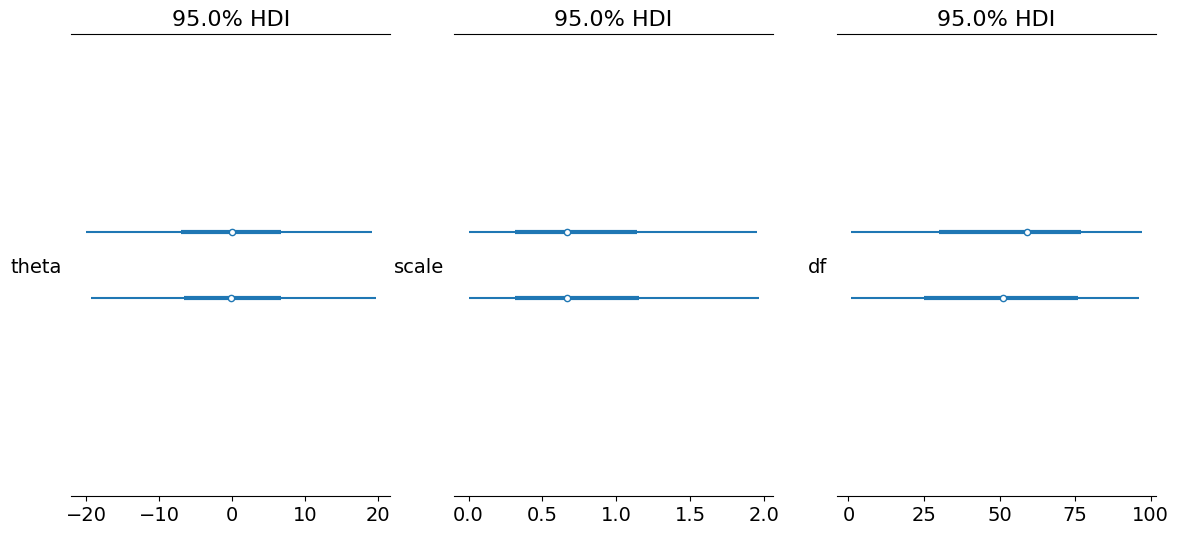

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(idata_HMC, var_names=["scale"], combined=False, hdi_prob=0.95, ax=ax[1])
az.plot_forest(idata_HMC, var_names=["df"], combined=False, hdi_prob=0.95, ax=ax[2])

HMC Split-Rhats {'theta': 1.0001, 'df': 1.0411, 'scale': 1.0001}


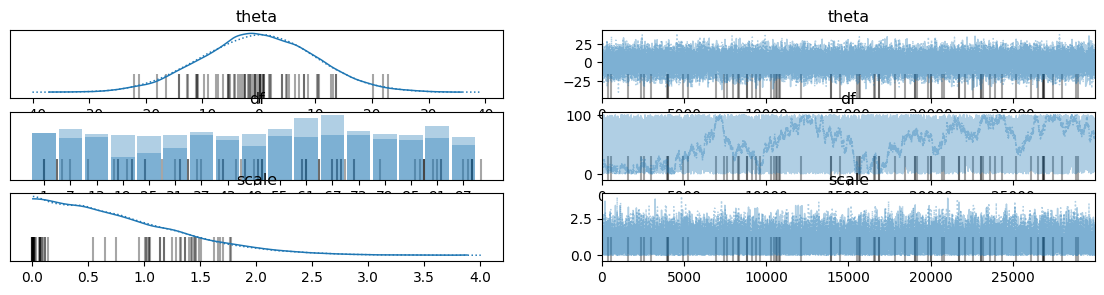

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:3,:2])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.06,9.99,-19.0,18.63,0.06,0.04,31157.53,31925.90,1.00
df,52.30,29.28,1.0,96.00,5.80,4.15,27.58,287.91,1.04
scale,0.79,0.60,0.0,1.87,0.00,0.00,19597.95,14071.87,1.00


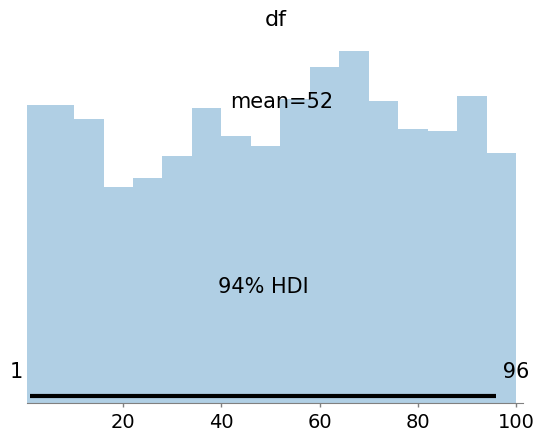

In [ ]:
pm.plot_posterior(idata_HMC, var_names=["df"])
az.summary(idata_HMC, round_to=2)

The df takes ~30000 samples in order to converge. The large number of samples and low effective sample size indicates that the algorithm is inefficient at exploring the sample space. This likely occurs due to the uniform distribution of the variable.

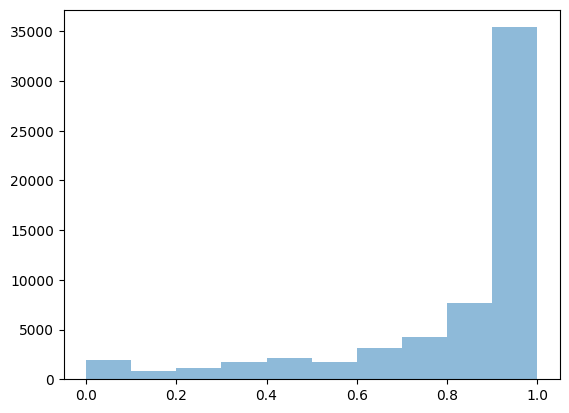

In [ ]:
plt.hist(idata_HMC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5);

**Part II:**

a) effective sample sizes:

Theta has a ESS of approxmately 1:1 to the sample size, indicating 100% efficiency of samples.

Scale is approximately 2:3, so it is is slightly less efficient.

As addressed previously, df has a very low ESS meaning the algorithm is inefficient.

b) chain convergence measures: With the sample size used, all three variables converge (r_hat < 1.05)

c) divergences: Out of a sample size of 30000, the first chain has 59 divergences and the second chain has 11. This is an acceptable number, given the large sample size.

d) Metropolis-Hastings acceptance rates: The acceptance rates are concentrated between 0.8 and 1.0, indicating optimal exploration.

e) No other warnings were issued